# Original Code from Brian's Mertics for distinguishing prbital precession from tidal decay paper!

## Editing to add Tess midtransit times

In [16]:
# Analyzing transit-timing data from A-thano+ (2022 - https://iopscience.iop.org/article/10.3847/1538-3881/ac416d)

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy.random import normal, uniform, choice

from utils import *
from fit_lin_model_to_prec_ephemeris import *

Ps_precession = 2.797440 # days
T0_precession = 2455642.14436 - 2450000. # BJD
omega_0 = -0.30 # rad
domega_dE = 0.0143 # rad/orbit
e = 0.0013
Pa_precession = Ps_precession/(1. - 1./2./np.pi*domega_dE)

num_precession_params = 5.
num_lin_params = 2.

filename = "Athano2022_Table6.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

In [24]:
# add in tess data
tess_file = "tess_hatp37_S40_fits.csv"
t_data = np.loadtxt(tess_file, delimiter=",", skiprows=1)

corrected_times = t_data[:, 1] - 2450000.  # time shift in A-thano 2022
print(corrected_times)
print(t_data[:, 0])


[9393.51259111 9396.31260035 9399.10879184 9401.90429562 9407.50061396
 9410.29508201 9413.0934963  9415.89007899]
[1340. 1341. 1342. 1343. 1345. 1346. 1347. 1348.]


Careful! You've zeroed out e!
[ 5.64214529e+03  2.79743858e+00 -1.66325251e-03 -2.15616659e+00
  1.94389260e-02]
[1.16164028e-03 1.61532090e-06 9.39704489e-04 9.94190582e-01
 1.30154554e-03]


/var/folders/5x/3m15_9vs2lnbtzh3mhf4mdlc0000gn/T/ipykernel_80801/2161290837.py:44: OptimizeWarning: Covariance of the parameters could not be estimated
  prec_popt, prec_cov = curve_fit(calc_ttra_precession, E_tra[:i], noisy_t_prec[:i],
/var/folders/5x/3m15_9vs2lnbtzh3mhf4mdlc0000gn/T/ipykernel_80801/2161290837.py:55: RuntimeWarning: invalid value encountered in sqrt
  running_Delta_BIC_sigma = 3.*np.sqrt(2.*(np.arange(0, len(E_tra)) - 3.))


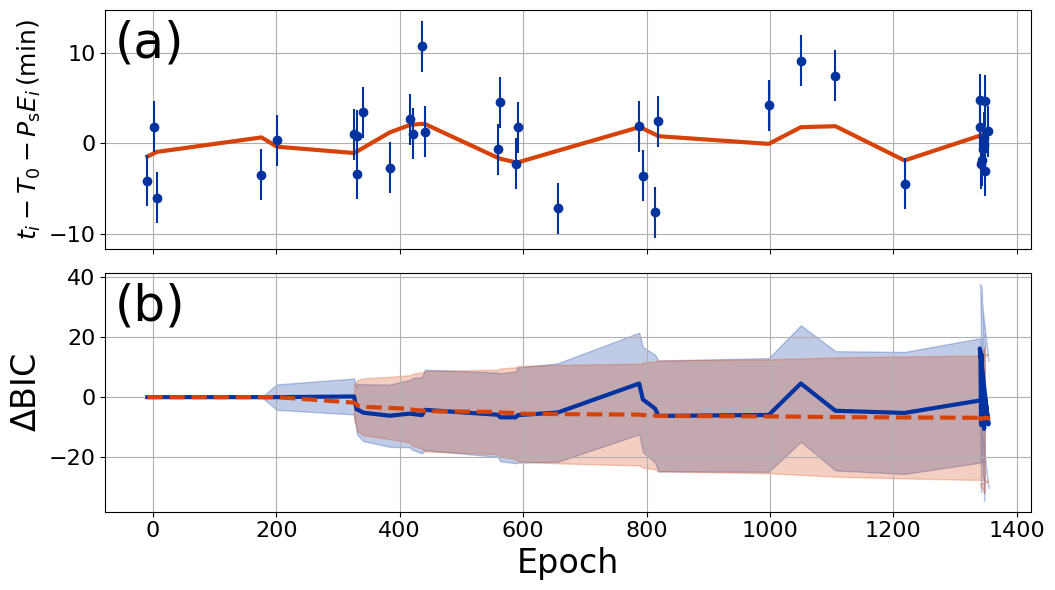

In [27]:
E_tra = np.concatenate((data['Epoch'], t_data[:, 0]))
sigma_tra = np.concatenate((data['sigma_Tm'], t_data[:, 2]))

print("Careful! You've zeroed out e!")
t_prec = calc_ttra_precession(E_tra, T0_precession, Ps_precession, 0., omega_0, domega_dE)
cosw = np.cos(domega_dE*E_tra + omega_0)
cur_sigma_tra = np.median(sigma_tra)*np.ones(len(E_tra))

num_sigma = 5
# noise = uniform(-num_sigma*cur_sigma_tra, num_sigma*cur_sigma_tra, size=len(E_tra))
noise = normal(scale=num_sigma*cur_sigma_tra, size=len(cur_sigma_tra))
noisy_t_prec = t_prec + noise

# Here is the actual correct uncertainty - see notes from 2025 Feb 7 for where this expression comes from
correct_sigma_tra = np.ones_like(sigma_tra)*np.sqrt(num_sigma**2/3.)*np.median(sigma_tra)
cur_sigma_tra = correct_sigma_tra

running_num_Delta_BIC = np.zeros(len(E_tra))
running_anal_Delta_BIC = np.zeros(len(E_tra))
# This should be the range in which we find the numerical Delta BIC
sigma_running_anal_Delta_BIC = np.zeros(len(E_tra))

for i in range(5, len(E_tra)):

    # Quasi-analytic estimate
    Delta_T0_prime = calc_T0_lin_factor(E_tra[:i], cosw[:i], cur_sigma_tra[:i])
    Delta_Ps_prime = calc_Ps_lin_factor(E_tra[:i], cosw[:i], cur_sigma_tra[:i])
    # anal_lin_chi_sq = (e*Pa/np.pi)**2*np.sum((cosw[:i] + Delta_Ps_prime*E_tra[:i] + Delta_T0_prime)**2/cur_sigma_tra[:i]**2) +\
    #     (len(E_tra[:i]) - 2.)

    # With e = 0, there is no first term
    anal_lin_chi_sq = (len(E_tra[:i]) - 2.)
    
    anal_lin_fit_BIC = anal_lin_chi_sq + num_lin_params*np.log(len(E_tra[:i]))
    anal_prec_BIC = (len(E_tra[:i]) - num_precession_params) + num_precession_params*np.log(len(E_tra[:i]))
    running_anal_Delta_BIC[i] = anal_lin_fit_BIC - anal_prec_BIC

    # Direct numerical estimate
    num_lin_fit_popt, num_lin_fit_pcov = np.polyfit(E_tra[:i], noisy_t_prec[:i], 1, cov='unscaled')
    num_lin_chi_sq = chisqg(noisy_t_prec[:i], np.polyval(num_lin_fit_popt, E_tra[:i]), sd=cur_sigma_tra[:i])

    num_lin_fit_BIC = num_lin_chi_sq + num_lin_params*np.log(len(E_tra[:i]))

    prec_popt, prec_cov = curve_fit(calc_ttra_precession, E_tra[:i], noisy_t_prec[:i], 
                                    sigma=cur_sigma_tra[:i], p0=[T0_precession, Ps_precession, e, omega_0, domega_dE])
    
    num_prec_chi_sq = chisqg(noisy_t_prec[:i], calc_ttra_precession(E_tra[:i], *prec_popt), sd=cur_sigma_tra[:i])
    
    num_prec_BIC = num_prec_chi_sq + num_precession_params*np.log(len(E_tra[:i]))
    running_num_Delta_BIC[i] = num_lin_fit_BIC - num_prec_BIC

print(prec_popt)
print(np.sqrt(np.diag(prec_cov)))
# What I think should be the range of Delta BIC
running_Delta_BIC_sigma = 3.*np.sqrt(2.*(np.arange(0, len(E_tra)) - 3.))

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)

ax1.plot(E_tra, (calc_ttra_precession(E_tra, *prec_popt) - np.polyval([prec_popt[1], prec_popt[0]], E_tra))*24.*60., 
         lw=3, color=BoiseState_orange)
ax1.errorbar(E_tra, (noisy_t_prec - np.polyval([prec_popt[1], prec_popt[0]], E_tra))*24.*60., yerr=cur_sigma_tra*24.*60., 
             ls='', marker='o', color=BoiseState_blue)

ax2.plot(E_tra, running_num_Delta_BIC, lw=3, color=BoiseState_blue, label="Numeric")
ax2.fill_between(E_tra, running_num_Delta_BIC - running_Delta_BIC_sigma, running_num_Delta_BIC + running_Delta_BIC_sigma, 
                 color=BoiseState_blue, alpha=0.25)
ax2.plot(E_tra, running_anal_Delta_BIC, lw=3, ls='--', color=BoiseState_orange, label="Analytic")

ax2.fill_between(E_tra[5:], (running_anal_Delta_BIC - running_Delta_BIC_sigma)[5:], 
                 (running_anal_Delta_BIC + running_Delta_BIC_sigma)[5:], 
                 color=BoiseState_orange, alpha=0.25)

ax1.grid(True)
ax2.grid(True)
ax1.tick_params(labelbottom=False, labelsize=16)
ax2.tick_params(labelsize=16)

ax1.set_ylabel(r'$t_i - T_0 - P_{\rm s} E_i\,\left( {\rm min}\right)$', fontsize=18)
ax2.set_xlabel("Epoch", fontsize=24)
ax2.set_ylabel(r'$\Delta {\rm BIC}$', fontsize=24)

ax1.text(0.01, 0.8, "(a)", fontsize=36, transform=ax1.transAxes)
ax2.text(0.01, 0.8, "(b)", fontsize=36, transform=ax2.transAxes)

# ax2.legend(loc='best', fontsize=16)

plt.tight_layout()
plt.show()